In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light58_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Wed Mar 10 21:31:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:0A:00.0 Off |                  N/A |
| 53%   75C    P2   261W / 280W |   9868MiB / 24220MiB |     63%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:42:00.0 Off |                  N/A |
| 74%   

In [3]:
save_dir = 'save/light58_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0  save_10000  save_1011  save_11473  save_5000  save_800


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 11473

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 204.7MiB
TTS size 117.1MiB
MelEncoder size 39.2MiB
MelDecoder size 70.8MiB
loaded : 11473
11473
done


In [15]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [16]:
t0 = time.time()
for i, batch in enumerate(train_loader):
    t1 = time.time()
    print(t1 - t0)
    t0 = time.time()
    if i > 10:
        break


2.0962281227111816
0.15844011306762695
0.0021979808807373047
0.0022687911987304688
0.23507404327392578
0.0021028518676757812
0.0020961761474609375
0.0019702911376953125
1.2477757930755615
0.15886378288269043
0.0019032955169677734
0.0018260478973388672


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8715ee7a0>
Traceback (most recent call last):
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/selectors.py", line 415, in select
    fd_

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.022586727142333986


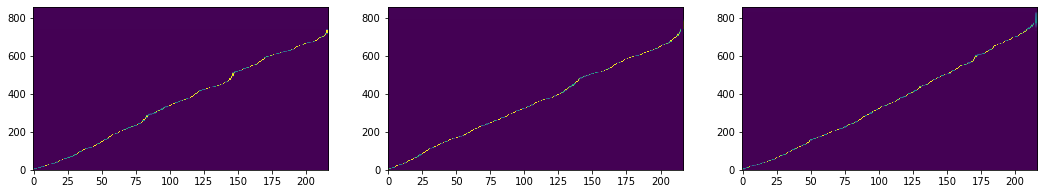

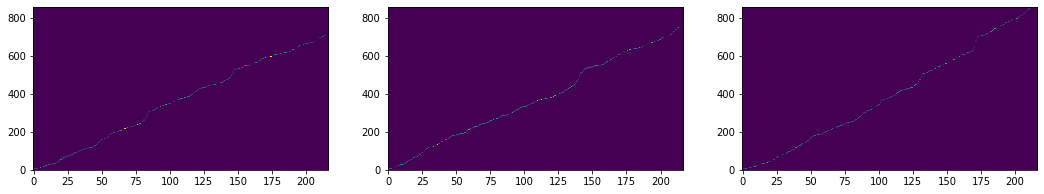

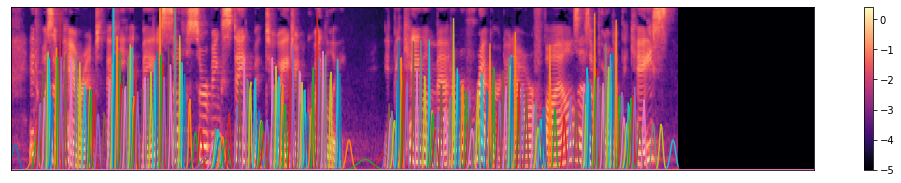

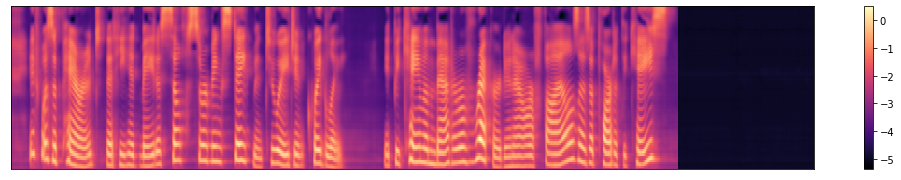

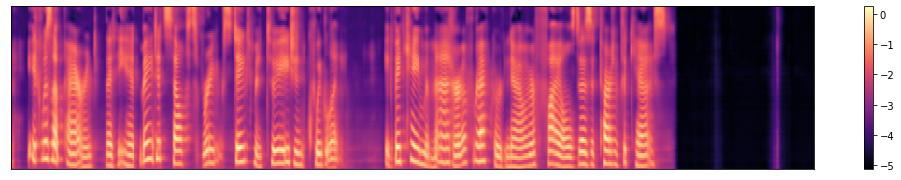

tensor(0.3119, device='cuda:0')
step : 19001 stt : 0.0083 tts : 0.1284 recon : 0.0269 kl : 0.0263 beta : 0.3801
tensor(0.8217, device='cuda:0')
step : 19002 stt : 0.0084 tts : 0.1426 recon : 0.0281 kl : 0.0280 beta : 0.3802
tensor(0.2675, device='cuda:0')
step : 19003 stt : 0.0095 tts : 0.1480 recon : 0.0253 kl : 0.0260 beta : 0.3802
tensor(0.3681, device='cuda:0')
step : 19004 stt : 0.0088 tts : 0.1384 recon : 0.0270 kl : 0.0260 beta : 0.3802
tensor(0.3408, device='cuda:0')
step : 19005 stt : 0.0106 tts : 0.1421 recon : 0.0266 kl : 0.0263 beta : 0.3802
tensor(0.4122, device='cuda:0')
step : 19006 stt : 0.0116 tts : 0.1562 recon : 0.0272 kl : 0.0270 beta : 0.3802
tensor(0.2757, device='cuda:0')
step : 19007 stt : 0.0109 tts : 0.1476 recon : 0.0286 kl : 0.0290 beta : 0.3803
tensor(0.2669, device='cuda:0')
step : 19008 stt : 0.0106 tts : 0.1320 recon : 0.0238 kl : 0.0254 beta : 0.3803
tensor(0.3655, device='cuda:0')
step : 19009 stt : 0.0086 tts : 0.1398 recon : 0.0259 kl : 0.0263 beta :

Process Process-165:
Traceback (most recent call last):
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/multiprocessing/queues.py", line 192, in _finalize_join
    thread.join()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/rubato/anaconda3/envs/espnet/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(blo

KeyboardInterrupt: 

In [17]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [18]:
logger.save(step, model, optimizer)

saved save/light58_model/save_19063


The Chronicles of Newgate, Volume two. By Arthur Griffiths. Section five: Newgate down to eighteen eighteen, part two.
torch.Size([1, 80, 680]) 0.011334555149078369
{'alignment': 0.0006368160247802734, 'random': 0.0001537799835205078, 'last_conv': 0.003542184829711914, 'z_proj': 0.0001761913299560547, 'cond': 0.0005788803100585938, 'up': 0.00024962425231933594, 'encode': 0.005827665328979492, 'pad': 4.1961669921875e-05, 'enc_conv': 0.0009777545928955078, 'enc_lstm': 0.004565000534057617}


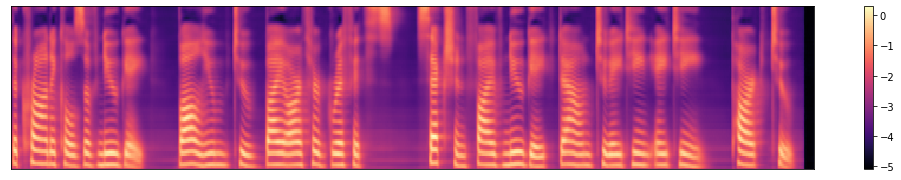

In [21]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in test_loader:
    batch = to_cuda(batch)
    print(batch['strings'][0])
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(100):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=0.3)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

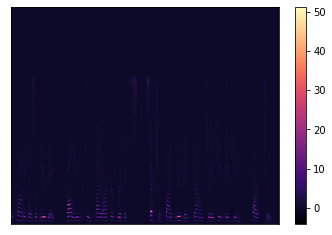

In [22]:
def denormalize(x):
    return 10 ** x

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)